# AFIB Detection Using 1D U-Net on Cleaned ECG Dataset

This notebook mirrors the data handling of the 1D-CNN pipeline but uses a 1D U-Net-style model for binary AFIB detection (AFIB vs SR).

Workflow:
1. Setup paths and load cleaned mapping
2. Verify data and prepare labels
3. Split dataset (train/val/test)
4. Compute global channel statistics
5. Define ECG dataset class
6. Create data loaders
7. Define and train 1D U-Net model
8. Evaluate on test set

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix, classification_report
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

print("✓ All imports successful")

✓ All imports successful


## 2. Configuration & Path Setup

In [2]:
# Hyperparameters
DOWNSAMPLE = 4  # Downsample factor (e.g., 2 = keep every 2nd sample)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths (all relative to project root where notebook is located)
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
CLEANED_ROOT = DATA_DIR / "cleaned_balanced_AFIB_SR"
CLEANED_WFDB_DIR = CLEANED_ROOT / "WFDBRecords"
MAPPING_CSV = CLEANED_ROOT / "file_mapping_cleaned.csv"

# Model save path
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "ecg_1dunet_afib_balanced.pth"

print(f"Device: {DEVICE}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"MAPPING_CSV: {MAPPING_CSV}")
print(f"MODEL_PATH: {MODEL_PATH}")
print("\n✓ Configuration complete")

Device: cuda
PROJECT_ROOT: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src
DATA_DIR: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\data
MAPPING_CSV: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\data\cleaned_balanced_AFIB_SR\file_mapping_cleaned.csv
MODEL_PATH: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\models\ecg_1dunet_afib_balanced.pth

✓ Configuration complete


## 3. Load Cleaned Mapping & Verify Data

In [3]:
# Load the cleaned mapping
cleaned_mapping = pd.read_csv(MAPPING_CSV)

print(f"Loaded {len(cleaned_mapping):,} records from {MAPPING_CSV.name}")
print(f"\nColumns: {list(cleaned_mapping.columns)}")

# Verify required columns exist
required_cols = ['record_id', 'ecg_path', '_AFIB', '_SR']
missing_cols = [col for col in required_cols if col not in cleaned_mapping.columns]
assert not missing_cols, f"Missing required columns: {missing_cols}"
print(f"✓ All required columns present: {required_cols}")

# Basic statistics
print(f"\n--- Dataset Statistics ---")
print(f"Total records: {len(cleaned_mapping):,}")
print(f"AFIB records (_AFIB=1): {cleaned_mapping['_AFIB'].sum():,}")
print(f"Non-AFIB records (_AFIB=0): {(cleaned_mapping['_AFIB'] == 0).sum():,}")
print(f"SR records (_SR=1): {cleaned_mapping['_SR'].sum():,}")
print(f"Non-SR records (_SR=0): {(cleaned_mapping['_SR'] == 0).sum():,}")

# Display sample rows
print("\nSample rows:")
cleaned_mapping.head()

Loaded 3,555 records from file_mapping_cleaned.csv

Columns: ['record_id', 'ecg_path', '_AFIB', '_SR']
✓ All required columns present: ['record_id', 'ecg_path', '_AFIB', '_SR']

--- Dataset Statistics ---
Total records: 3,555
AFIB records (_AFIB=1): 1,780
Non-AFIB records (_AFIB=0): 1,775
SR records (_SR=1): 1,775
Non-SR records (_SR=0): 1,780

Sample rows:


,record_id,ecg_path,_AFIB,_SR
0,JS36340,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
1,JS04305,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,1,0
2,JS11050,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
3,JS23632,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
4,JS41351,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1


## 4. Prepare Labels for Binary AFIB Detection

In [4]:
# Use _AFIB as the primary target column
target_col = "_AFIB"

# Ensure target is strictly 0/1
cleaned_mapping[target_col] = pd.to_numeric(cleaned_mapping[target_col], errors='coerce').fillna(0)
cleaned_mapping[target_col] = (cleaned_mapping[target_col] > 0).astype(int)

print(f"Target column: {target_col}")
print("Target distribution:")
print(cleaned_mapping[target_col].value_counts().sort_index())
print("\n✓ Labels prepared for binary AFIB detection")

Target column: _AFIB
Target distribution:
_AFIB
0    1775
1    1780
Name: count, dtype: int64

✓ Labels prepared for binary AFIB detection


## 5. Split Dataset (Train/Val/Test)

In [5]:
# Create indices array
indices = np.arange(len(cleaned_mapping))
labels = cleaned_mapping[target_col].values

# First split: 80% train, 20% temp
idx_train, idx_temp, y_train, y_temp = train_test_split(
    indices, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Second split: temp into 50% val, 50% test
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("--- Dataset Splits ---")
print(f"Train: {len(idx_train):,} samples (AFIB: {y_train.sum():,}, Non-AFIB: {(y_train == 0).sum():,})")
print(f"Val:   {len(idx_val):,} samples (AFIB: {y_val.sum():,}, Non-AFIB: {(y_val == 0).sum():,})")
print(f"Test:  {len(idx_test):,} samples (AFIB: {y_test.sum():,}, Non-AFIB: {(y_test == 0).sum():,})")
print("\n✓ Dataset split complete")

--- Dataset Splits ---
Train: 2,844 samples (AFIB: 1,424, Non-AFIB: 1,420)
Val:   355 samples (AFIB: 178, Non-AFIB: 177)
Test:  356 samples (AFIB: 178, Non-AFIB: 178)

✓ Dataset split complete


## 6. Compute Global Channel Statistics

In [6]:
def compute_channel_stats(mapping, indices, downsample=None, max_samples=512):
    """
    Compute global per-channel mean and std from a subset of training data.
    Stacks up to max_samples random samples to estimate statistics.
    """
    if len(indices) > max_samples:
        sample_indices = np.random.choice(indices, size=max_samples, replace=False)
    else:
        sample_indices = indices

    data_list = []
    checked_count = 0
    loaded_count = 0

    for idx in sample_indices:
        row = mapping.iloc[int(idx)]
        npy_file = Path(row["ecg_path"])
        
        # Debug: print first few paths
        if checked_count < 3:
            print(f"  Checking path {checked_count + 1}: {npy_file}")
        
        # Resolve relative paths against PROJECT_ROOT
        if not npy_file.is_absolute():
            npy_file = (PROJECT_ROOT / npy_file).resolve()
            if checked_count < 3:
                print(f"    Resolved to: {npy_file}")
        
        checked_count += 1
        
        if not npy_file.exists():
            if checked_count <= 3:
                print(f"    File does not exist!")
            continue
        
        if checked_count <= 3:
            print(f"    File exists! Loading...")
            
        try:
            data = np.load(npy_file)
            # Ensure 2D array and shape (12, L) or (L, 12)
            if data.ndim != 2:
                continue
            if data.shape[0] > data.shape[1]:
                # Possibly (L, 12); transpose to (12, L)
                data = data.T
            if data.shape[0] != 12:
                continue
            if downsample is not None and downsample > 1:
                data = data[:, ::downsample]
            # Replace NaN/Inf
            data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
            data_list.append(data)
            loaded_count += 1
        except Exception as e:
            if checked_count <= 3:
                print(f"    Error loading: {e}")
            continue

    print(f"  Checked {checked_count} files, successfully loaded {loaded_count}")
    
    if not data_list:
        raise ValueError(f"No valid data loaded for computing statistics (checked {checked_count} paths)")

    # Align lengths to stack
    min_len = min(arr.shape[1] for arr in data_list)
    data_list = [arr[:, :min_len] for arr in data_list]
    stack = np.stack(data_list, axis=0)  # (N, 12, T)

    mean = stack.mean(axis=(0, 2)).astype(np.float32)
    std = (stack.std(axis=(0, 2)) + 1e-6).astype(np.float32)
    mean = np.nan_to_num(mean, nan=0.0, posinf=0.0, neginf=0.0)
    std = np.nan_to_num(std, nan=1.0, posinf=1.0, neginf=1.0)
    return mean, std

print("✓ Function defined: compute_channel_stats")

✓ Function defined: compute_channel_stats


In [7]:
# Compute global statistics from training set
print("Computing global channel statistics from training data...")
global_mean, global_std = compute_channel_stats(
    cleaned_mapping,
    idx_train,
    downsample=DOWNSAMPLE,
    max_samples=512
)

print(f"\nGlobal mean (per channel): {global_mean}")
print(f"Global std (per channel):  {global_std}")
print("\n✓ Channel statistics computed")

Computing global channel statistics from training data...
  Checking path 1: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\cleaned_balanced_AFIB_SR\WFDBRecords\JS\JS04385\JS04385.npy
    File exists! Loading...
  Checking path 2: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\cleaned_balanced_AFIB_SR\WFDBRecords\JS\JS40150\JS40150.npy
    File exists! Loading...
  Checking path 3: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\cleaned_balanced_AFIB_SR\WFDBRecords\JS\JS11836\JS11836.npy
    File exists! Loading...
  Checked 512 files, successfully loaded 512

Global mean (per channel): [ 0.00127785  0.00365587  0.00237572 -0.00127454 -0.00173943  0.00182272
 -0.00155246  0.0025391   0.00258249  0.00315001  0.002271    0.00032215]
Global std (per channel):  [0.13801949 0.15852875 0.13577366 0.13222094 0.11162702 0.13046591
 0.19967413 0.35216072 0.372176

## 7. Define ECG Dataset Class

In [8]:
class ECGDataset(Dataset):
    """PyTorch Dataset for ECG data that loads from .npy files."""
    def __init__(self, mapping, indices, downsample=None, target_col="_AFIB",
                 channel_mean=None, channel_std=None):
        self.mapping = mapping.iloc[indices].reset_index(drop=True)
        self.downsample = downsample
        self.target_col = target_col
        self.channel_mean = channel_mean if channel_mean is not None else np.zeros(12, dtype=np.float32)
        self.channel_std = channel_std if channel_std is not None else np.ones(12, dtype=np.float32)

    def __len__(self):
        return len(self.mapping)

    def __getitem__(self, idx):
        row = self.mapping.iloc[idx]
        record_id = str(row["record_id"])
        npy_file = Path(row["ecg_path"])
        # Resolve relative paths against PROJECT_ROOT
        if not npy_file.is_absolute():
            npy_file = (PROJECT_ROOT / npy_file).resolve()
        if not npy_file.exists():
            # Fallback dummy
            data = np.zeros((12, 2500), dtype=np.float32)
        else:
            try:
                data = np.load(npy_file)
                # Ensure 2D array and shape (12, L)
                if data.ndim != 2:
                    raise ValueError(f"Expected 2D array, got shape {data.shape}")
                if data.shape[0] > data.shape[1]:
                    data = data.T
                if data.shape[0] != 12:
                    raise ValueError(f"Expected 12 channels, got {data.shape[0]}")
                if self.downsample is not None and self.downsample > 1:
                    data = data[:, ::self.downsample]
                # Replace NaN/Inf
                data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
                # Normalize
                data = (data - self.channel_mean[:, None]) / self.channel_std[:, None]
                data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
                data = data.astype(np.float32)
            except Exception as e:
                print(f"Error loading {record_id}: {e}")
                data = np.zeros((12, 2500), dtype=np.float32)
        try:
            tval = float(row[self.target_col])
            label = 1.0 if tval > 0 else 0.0
        except Exception:
            label = 0.0
        data_tensor = torch.from_numpy(data).float()
        label_tensor = torch.tensor(label, dtype=torch.float32)
        return data_tensor, label_tensor

print("✓ ECGDataset class defined")

✓ ECGDataset class defined


## 8. Create DataLoaders

In [9]:
# Create datasets
train_ds = ECGDataset(cleaned_mapping, idx_train, downsample=DOWNSAMPLE, target_col="_AFIB",
                       channel_mean=global_mean, channel_std=global_std)
val_ds = ECGDataset(cleaned_mapping, idx_val, downsample=DOWNSAMPLE, target_col="_AFIB",
                     channel_mean=global_mean, channel_std=global_std)
test_ds = ECGDataset(cleaned_mapping, idx_test, downsample=DOWNSAMPLE, target_col="_AFIB",
                      channel_mean=global_mean, channel_std=global_std)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader:   {len(val_loader)} batches")
print(f"Test loader:  {len(test_loader)} batches")
print("\n✓ DataLoaders created")

Train loader: 89 batches
Val loader:   12 batches
Test loader:  12 batches

✓ DataLoaders created


## 9. Define 1D U-Net Model

In [10]:
def conv_block(in_ch, out_ch, k=3, p=1):
    return nn.Sequential(
        nn.Conv1d(in_ch, out_ch, kernel_size=k, padding=p),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv1d(out_ch, out_ch, kernel_size=k, padding=p),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(inplace=True)
    )

class UNet1D(nn.Module):
    def __init__(self, in_channels=12, base_ch=32):
        super().__init__()
        # Encoder
        self.enc1 = conv_block(in_channels, base_ch)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = conv_block(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = conv_block(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool1d(2)
        self.bottleneck = conv_block(base_ch*4, base_ch*8)
        # Decoder
        self.up3 = nn.ConvTranspose1d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = conv_block(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose1d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = conv_block(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose1d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = conv_block(base_ch*2, base_ch)
        # Output head: per-time-step logit
        self.out = nn.Conv1d(base_ch, 1, kernel_size=1)
        # Global pooling to get single logit per record
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        b = self.bottleneck(p3)
        # Decoder with dimension alignment at skip connections
        u3 = self.up3(b)
        min_len = min(u3.shape[-1], e3.shape[-1])
        u3 = u3[..., :min_len]
        e3_crop = e3[..., :min_len]
        d3 = self.dec3(torch.cat([u3, e3_crop], dim=1))
        
        u2 = self.up2(d3)
        min_len = min(u2.shape[-1], e2.shape[-1])
        u2 = u2[..., :min_len]
        e2_crop = e2[..., :min_len]
        d2 = self.dec2(torch.cat([u2, e2_crop], dim=1))
        
        u1 = self.up1(d2)
        min_len = min(u1.shape[-1], e1.shape[-1])
        u1 = u1[..., :min_len]
        e1_crop = e1[..., :min_len]
        d1 = self.dec1(torch.cat([u1, e1_crop], dim=1))
        
        # Time logits and global pooling
        tlogits = self.out(d1)  # (B, 1, T)
        pooled = self.global_pool(tlogits).squeeze(-1)  # (B, 1)
        return pooled.squeeze(1)  # (B)

model = UNet1D(in_channels=12, base_ch=32).to(DEVICE)
print(f"Model architecture:\n{model}")
print(f"\n✓ 1D U-Net model initialized on {DEVICE}")

Model architecture:
UNet1D(
  (enc1): Sequential(
    (0): Conv1d(12, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e

## 10. Training Setup

In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Loss function: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print("\n✓ Training setup complete")

Loss function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.001)

✓ Training setup complete


## 11. Training Loop

In [12]:
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': [], 'val_f1': []}
best_val_auc = 0.0

print(f"Starting training for {NUM_EPOCHS} epochs...\n")
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)  # (B)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / max(1, len(train_loader))

    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)  # (B)
            loss = criterion(output, target)
            val_loss += loss.item()
            probs = torch.sigmoid(output).cpu().numpy()
            all_preds.extend(probs)
            all_targets.extend(target.cpu().numpy())
    avg_val_loss = val_loss / max(1, len(val_loader))
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    val_auc = roc_auc_score(all_targets, all_preds) if len(np.unique(all_targets)) > 1 else 0.5
    val_acc = accuracy_score(all_targets, (all_preds > 0.5).astype(int))
    val_f1 = f1_score(all_targets, (all_preds > 0.5).astype(int), zero_division=0)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  → Best model saved (AUC: {val_auc:.4f})")

print(f"\n✓ Training complete!")
print(f"Best validation AUC: {best_val_auc:.4f}")

Starting training for 30 epochs...

Epoch [1/30] Train Loss: 0.3276 | Val Loss: 0.0933 | Val AUC: 0.9976 | Val Acc: 0.9803 | Val F1: 0.9806
  → Best model saved (AUC: 0.9976)
Epoch [2/30] Train Loss: 0.1000 | Val Loss: 0.0724 | Val AUC: 1.0000 | Val Acc: 0.9859 | Val F1: 0.9861
  → Best model saved (AUC: 1.0000)
Epoch [3/30] Train Loss: 0.0510 | Val Loss: 0.0556 | Val AUC: 1.0000 | Val Acc: 0.9972 | Val F1: 0.9972
Epoch [4/30] Train Loss: 0.0357 | Val Loss: 0.0393 | Val AUC: 0.9998 | Val Acc: 0.9887 | Val F1: 0.9889
Epoch [5/30] Train Loss: 0.0351 | Val Loss: 0.0326 | Val AUC: 0.9996 | Val Acc: 0.9915 | Val F1: 0.9916
Epoch [6/30] Train Loss: 0.0177 | Val Loss: 0.0236 | Val AUC: 0.9998 | Val Acc: 0.9915 | Val F1: 0.9916
Epoch [7/30] Train Loss: 0.0117 | Val Loss: 0.0238 | Val AUC: 0.9999 | Val Acc: 0.9915 | Val F1: 0.9916
Epoch [8/30] Train Loss: 0.0126 | Val Loss: 0.0351 | Val AUC: 0.9989 | Val Acc: 0.9887 | Val F1: 0.9888
Epoch [9/30] Train Loss: 0.0268 | Val Loss: 0.0627 | Val AUC: 

## 12. Load Best Model & Evaluate on Test Set

In [13]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print(f"Loaded best model from {MODEL_PATH}")
print("\nEvaluating on test set...\n")

test_loss = 0.0
all_test_preds, all_test_targets = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)  # (B)
        loss = criterion(output, target)
        test_loss += loss.item()
        probs = torch.sigmoid(output).cpu().numpy()
        all_test_preds.extend(probs)
        all_test_targets.extend(target.cpu().numpy())
avg_test_loss = test_loss / max(1, len(test_loader))
all_test_preds = np.array(all_test_preds)
all_test_targets = np.array(all_test_targets)

test_auc = roc_auc_score(all_test_targets, all_test_preds) if len(np.unique(all_test_targets)) > 1 else 0.5
test_pred_labels = (all_test_preds > 0.5).astype(int)
test_acc = accuracy_score(all_test_targets, test_pred_labels)
test_pre = precision_score(all_test_targets, test_pred_labels, zero_division=0)
test_rec = recall_score(all_test_targets, test_pred_labels, zero_division=0)
cm = confusion_matrix(all_test_targets, test_pred_labels, labels=[0,1])
TN, FP, FN, TP = cm.ravel()
test_spec = TN / (TN + FP) if (TN + FP) > 0 else np.nan
test_f1 = f1_score(all_test_targets, test_pred_labels, zero_division=0)
test_mcc = matthews_corrcoef(all_test_targets, test_pred_labels)

print("--- Test Set Results ---")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Test Acc:  {test_acc:.4f}")
print(f"Test Pre:  {test_pre:.4f}")
print(f"Test Rec:  {test_rec:.4f}")
print(f"Test Spec: {test_spec:.4f}")
print(f"Test F1:   {test_f1:.4f}")
print(f"Test MCC:  {test_mcc:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_test_targets, test_pred_labels, target_names=['Non-AFIB', 'AFIB']))

Loaded best model from c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\models\ecg_1dunet_afib_balanced.pth

Evaluating on test set...



C:\Users\Adrian\AppData\Local\Temp\ipykernel_8052\753648619.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


--- Test Set Results ---
Test Loss: 0.0663
Test AUC:  0.9998
Test Acc:  0.9860
Test Pre:  0.9727
Test Rec:  1.0000
Test Spec: 0.9719
Test F1:   0.9861
Test MCC:  0.9723

Confusion Matrix:
[[173   5]
 [  0 178]]

Classification Report:
              precision    recall  f1-score   support

    Non-AFIB       1.00      0.97      0.99       178
        AFIB       0.97      1.00      0.99       178

    accuracy                           0.99       356
   macro avg       0.99      0.99      0.99       356
weighted avg       0.99      0.99      0.99       356



## 13. Visualize Confusion Matrix

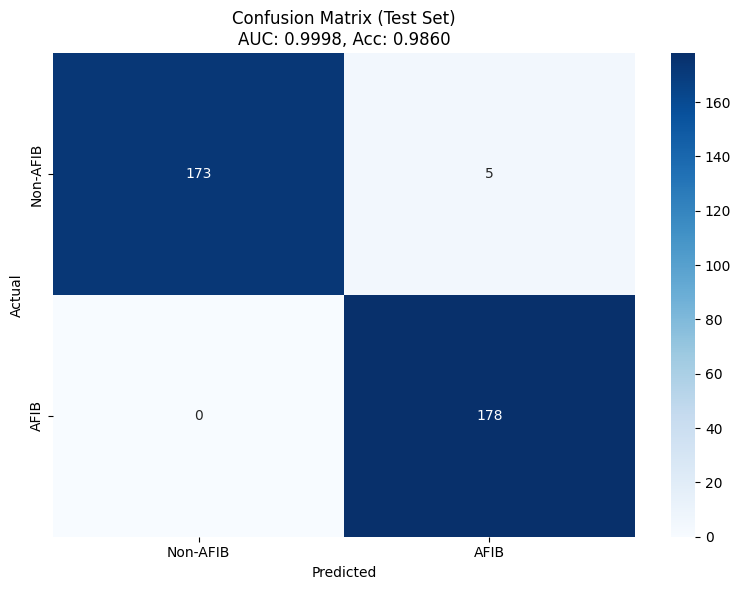


✓ AFIB detection pipeline complete!


In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-AFIB', 'AFIB'],
            yticklabels=['Non-AFIB', 'AFIB'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test Set)\nAUC: {test_auc:.4f}, Acc: {test_acc:.4f}')
plt.tight_layout()
plt.show()

print("\n============================================================")
print("✓ AFIB detection pipeline complete!")
print("============================================================")

## 14. ROC Curve (Receiver Operating Characteristic)

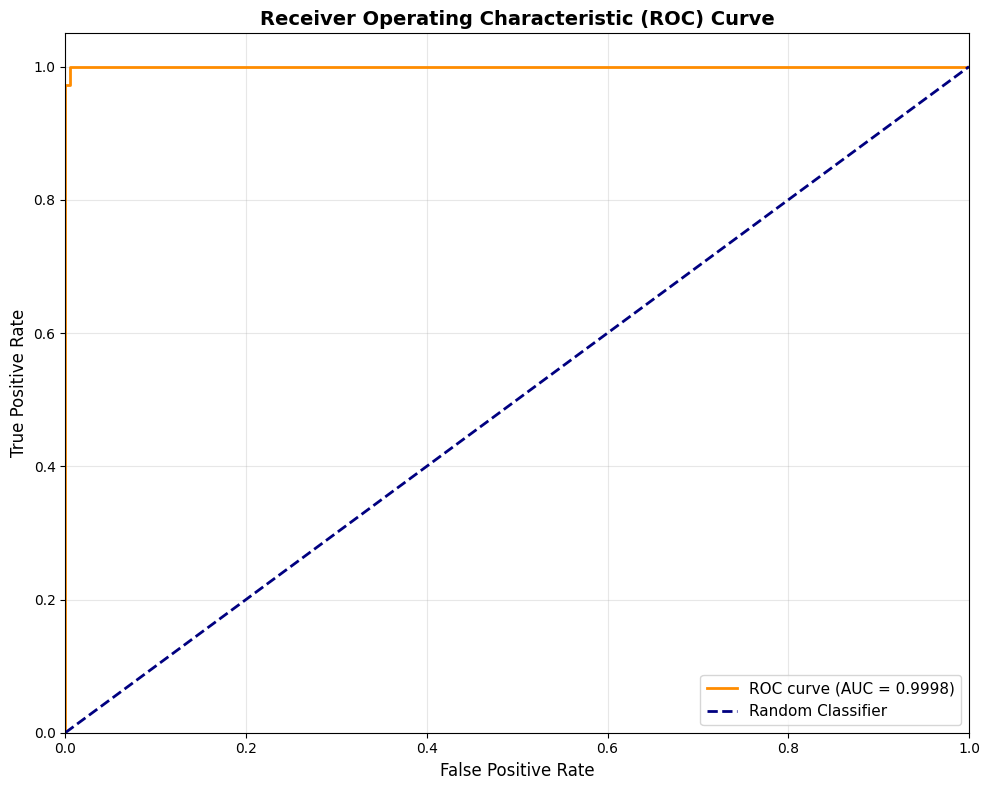

ROC-AUC Score: 0.9998


In [15]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_test_targets, all_test_preds)
roc_auc_curve = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_curve:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc_curve:.4f}")

## 15. DET Curve (Detection Error Tradeoff)

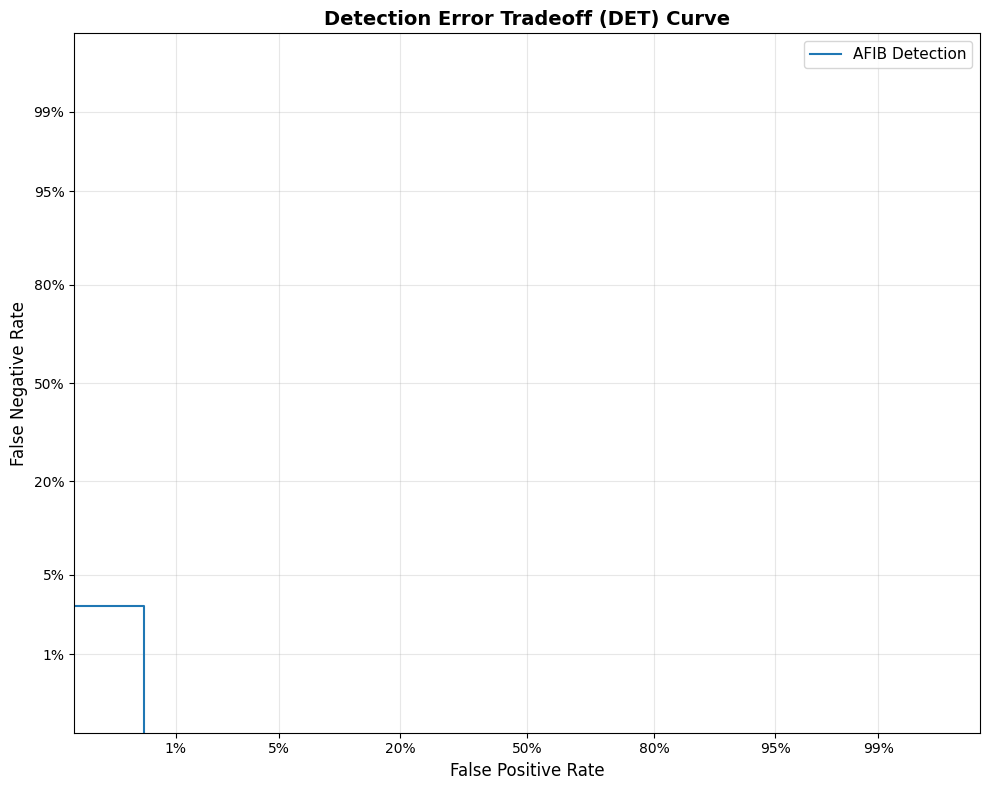

DET Curve: Lower values indicate better performance
The curve shows the tradeoff between false positives and false negatives


In [16]:
from sklearn.metrics import DetCurveDisplay

# Create and plot DET curve
fig, ax = plt.subplots(figsize=(10, 8))
DetCurveDisplay.from_predictions(all_test_targets, all_test_preds, ax=ax, name='AFIB Detection')

ax.set_title('Detection Error Tradeoff (DET) Curve', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('False Negative Rate', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.show()

print("DET Curve: Lower values indicate better performance")
print(f"The curve shows the tradeoff between false positives and false negatives")

## 16. Metrics Summary

In [17]:
# Compute all metrics from test results
acc = test_acc
f1 = test_f1
pre = test_pre
rec = test_rec
spec = test_spec
mcc = test_mcc
roc_auc = test_auc

print(f"Acc:  {acc:.3f}")
print(f"F1:   {f1:.3f}")
print(f"Pre:  {pre:.3f}")
print(f"Rec:  {rec:.3f}")
print(f"Spec: {spec:.3f}")
print(f"MCC:  {mcc:.3f}")
print(f"AUC:  {roc_auc:.3f}")

Acc:  0.986
F1:   0.986
Pre:  0.973
Rec:  1.000
Spec: 0.972
MCC:  0.972
AUC:  1.000


In [18]:

# Save results to results folder
from datetime import datetime

# Create results directory if it doesn't exist
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Calculate sample rate (original 500 Hz downsampled by factor DOWNSAMPLE)
original_sample_rate = 500  # Hz
sample_rate = original_sample_rate / DOWNSAMPLE  # Hz

# Generate results file
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = "1D-UNET"
results_filename = RESULTS_DIR / f"results_{model_name}_{timestamp}.txt"

# Format results text
results_text = f"""
================================================================================
AFIB Detection Model Results
================================================================================
Model Name:        {model_name}
Sample Rate:       {sample_rate:.1f} Hz (Original: {original_sample_rate} Hz, Downsample: {DOWNSAMPLE}x)
Batch Size:        {BATCH_SIZE}
Learning Rate:     {LEARNING_RATE}
Num Epochs:        {NUM_EPOCHS}
Device:            {DEVICE}
Timestamp:         {timestamp}

================================================================================
Test Set Metrics
================================================================================
Accuracy (Acc):    {acc:.4f}
F1-Score (F1):     {f1:.4f}
Precision (Pre):   {pre:.4f}
Recall (Rec):      {rec:.4f}
Specificity (Spec):{spec:.4f}
Matthews Corr Coef:{mcc:.4f}
ROC-AUC (AUC):     {roc_auc:.4f}

Test Loss:         {avg_test_loss:.4f}

================================================================================
Confusion Matrix
================================================================================
                  Predicted
               Non-AFIB  AFIB
Actual Non-AFIB    {TN:>4d}    {FP:>4d}
       AFIB        {FN:>4d}    {TP:>4d}

TP (True Positive):   {TP}
TN (True Negative):   {TN}
FP (False Positive):  {FP}
FN (False Negative):  {FN}

================================================================================
"""

# Write to file
with open(results_filename, 'w') as f:
    f.write(results_text)

print(f"✓ Results saved to: {results_filename}")
print(results_text)


✓ Results saved to: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\src\results\results_1D-UNET_2025-12-16_14-08-57.txt

AFIB Detection Model Results
Model Name:        1D-UNET
Sample Rate:       125.0 Hz (Original: 500 Hz, Downsample: 4x)
Batch Size:        32
Learning Rate:     0.001
Num Epochs:        30
Device:            cuda
Timestamp:         2025-12-16_14-08-57

Test Set Metrics
Accuracy (Acc):    0.9860
F1-Score (F1):     0.9861
Precision (Pre):   0.9727
Recall (Rec):      1.0000
Specificity (Spec):0.9719
Matthews Corr Coef:0.9723
ROC-AUC (AUC):     0.9998

Test Loss:         0.0663

Confusion Matrix
                  Predicted
               Non-AFIB  AFIB
Actual Non-AFIB     173       5
       AFIB           0     178

TP (True Positive):   178
TN (True Negative):   173
FP (False Positive):  5
FN (False Negative):  0


